In [312]:
import os
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

In [304]:
data_exp = pd.read_csv('expression_data.csv')
data_ic50 = pd.read_csv('ic50_data.csv')

data_exp = data_exp.iloc[:,1:]
data_ic50 = data_ic50.iloc[:,1:]

In [305]:
data = pd.merge(data_exp, data_ic50, on=['cell_line'], how='inner')

In [266]:
#data_check = pd.merge(data_exp, data_ic50, on=['cell_line'], how='outer', indicator=True)

In [306]:
data.head()

,cell_line,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,...,OR7M1P,PAXIP1-DT,OR5B15P,LINC02712,LINC02725,OR13I1P,LOC105372990,Drug.Name,Drug.ID,IC50
0,A101D_SKIN,0.600058,0.0,1.309944,0.811589,1.015967,0.0,0.024312,1.366059,1.448566,...,0.885542,0.858391,0,24.5,0.0,0.0,0.340278,(5Z)-7-Oxozeaenol,1242,-1.101155
1,A101D_SKIN,0.600058,0.0,1.309944,0.811589,1.015967,0.0,0.024312,1.366059,1.448566,...,0.885542,0.858391,0,24.5,0.0,0.0,0.340278,123138,1824,3.533976
2,A101D_SKIN,0.600058,0.0,1.309944,0.811589,1.015967,0.0,0.024312,1.366059,1.448566,...,0.885542,0.858391,0,24.5,0.0,0.0,0.340278,123829,1820,3.627938
3,A101D_SKIN,0.600058,0.0,1.309944,0.811589,1.015967,0.0,0.024312,1.366059,1.448566,...,0.885542,0.858391,0,24.5,0.0,0.0,0.340278,150412,1836,3.642094
4,A101D_SKIN,0.600058,0.0,1.309944,0.811589,1.015967,0.0,0.024312,1.366059,1.448566,...,0.885542,0.858391,0,24.5,0.0,0.0,0.340278,5-azacytidine,2156,1.200924


In [307]:
data = data.drop_duplicates(subset=['cell_line','Drug.Name'], keep='last')

In [265]:
#data_check[(data_check['Drug.Name']=='Cisplatin') & (data_check['_merge']=='both')]

## loop for a list of drugs

In [527]:
drug_list = ['Dacarbazine','Temozolomide','Paclitaxel','Cisplatin','Dabrafenib','Trametinib','Nilotinib','Dasatinib']
#drug_list = ['Temozolomide']

param_grid = {
    'n_estimators':[10, 50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 10, 25]
}

model_name = "RF"
#model_name = "LR"

In [309]:
# evaluation metrics
def eval_metrics(pred, true):
    df_pred = pd.DataFrame(pred).reset_index().drop(columns=['index'])
    df_true = pd.DataFrame(true).reset_index().drop(columns=['index'])
    result = pd.concat([df_pred, df_true], axis=1, ignore_index=True)
    result.columns=["Predicted", "Test"]

    rse = ((result['Predicted']-result['Test'])**2).sum()
    mse = rse / len(result)
    rmse = np.sqrt(mse)
    
    r2_value = r2_score(result['Test'], result['Predicted'])

    return rmse, r2_value

### models

drug name: Dacarbazine
14 train samples
6 test samples
model feature count = 18
cross validation rmse value = 0.10828937297544956
cross validation r-squared value = -3.8513898663062043
test rmse value = 0.7894294562289744
test r-squared value = -0.22427670645127207
{'max_depth': 3, 'max_features': 25, 'min_samples_split': 2, 'n_estimators': 10}
------------------------------
drug name: Temozolomide
21 train samples
9 test samples
model feature count = 26
cross validation rmse value = 0.6758869546644929
cross validation r-squared value = 0.6355243969939685
test rmse value = 0.6617148093771507
test r-squared value = 0.23107393114579833
{'max_depth': 5, 'max_features': 25, 'min_samples_split': 2, 'n_estimators': 200}
------------------------------
drug name: Paclitaxel
21 train samples
9 test samples
model feature count = 26
cross validation rmse value = 0.5044489890481543
cross validation r-squared value = 0.6698631471223087
test rmse value = 1.065527792094189
test r-squared value = 0.17

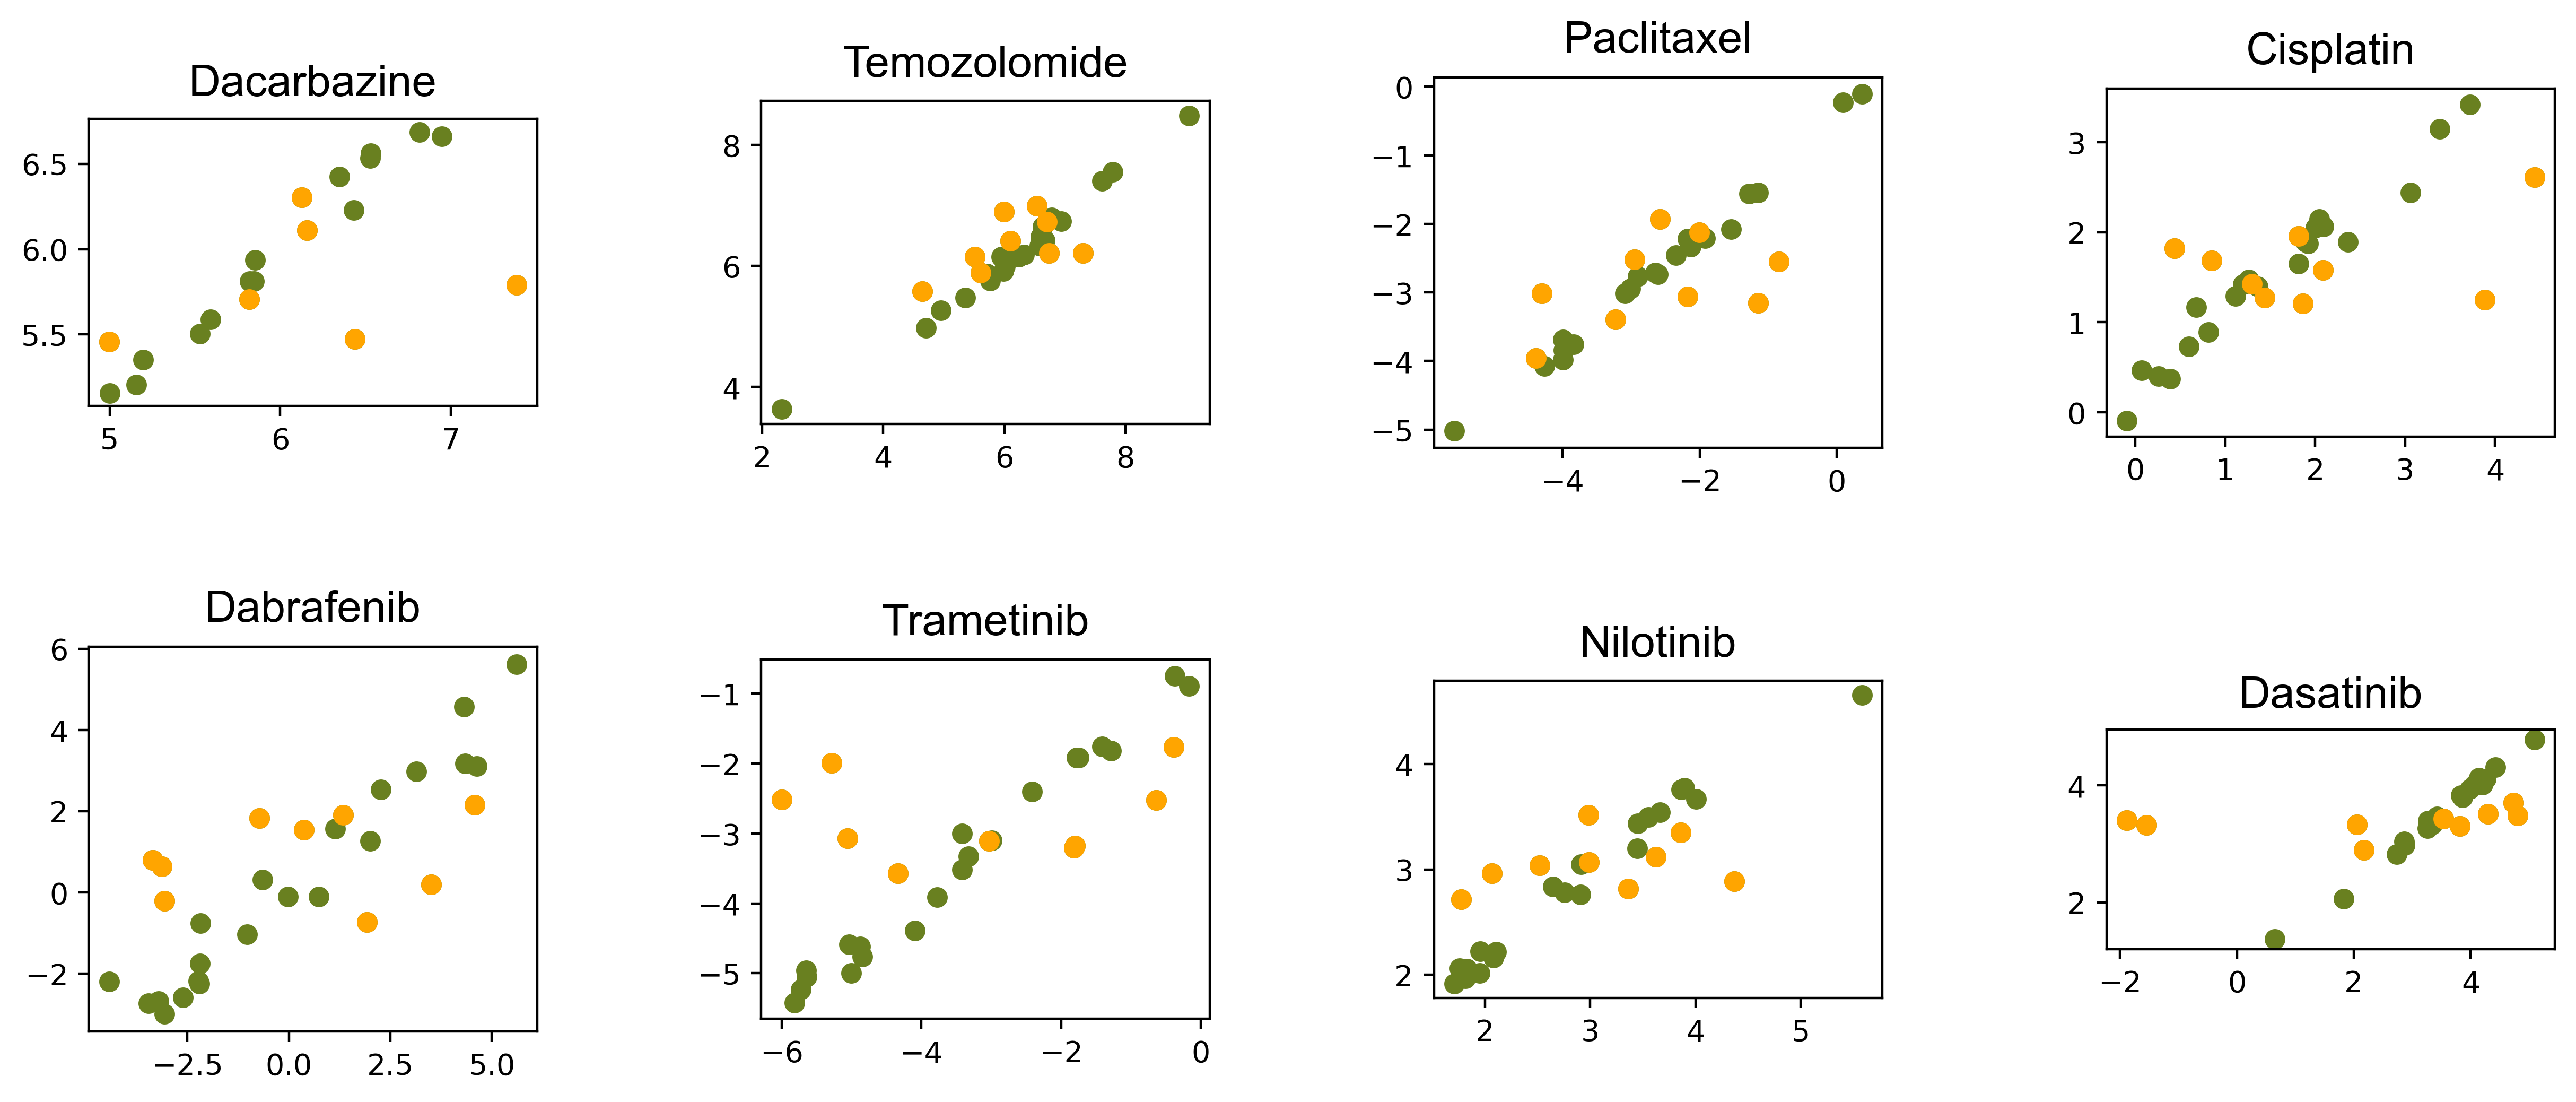

In [528]:
result_df = pd.DataFrame()
rmselist = []
r2list = []

fig = plt.figure(figsize=(15,20),dpi=400)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
num = 1

for drug in drug_list:
    # filter input data to model
    input = data[data['Drug.Name']==drug]

    # train test split
    train, test = train_test_split(input, test_size=0.3, random_state=1)
    
    x_train = train.drop(columns=['cell_line','Drug.Name','Drug.ID','IC50'])
    y_train = train['IC50']
    
    x_test = test.drop(columns=['cell_line','Drug.Name','Drug.ID','IC50'])
    y_test = test['IC50']

    # scaler
    scaler = StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # feature selection
    sel_ = SelectFromModel(Lasso(alpha=1e-3, random_state=1, max_iter=10000)) #1e-5, 1e-4
    sel_.fit(x_train_scaled, y_train)

    x_train_sel = sel_.transform(x_train_scaled)
    x_test_sel = sel_.transform(x_test_scaled)

    # train the predictor

    if model_name=="RF":
        
        model = RandomForestRegressor(random_state=1)
        # grid search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
        grid_search.fit(x_train_sel, y_train)
        best_params = grid_search.best_params_
    
        # fit model
        model = RandomForestRegressor(random_state=1, **best_params)      
        #model = RandomForestRegressor(random_state=1, n_estimators=200, max_features=25)
        
        model.fit(x_train_sel, y_train)
        
    elif model_name=="LR":
        model = Ridge(alpha=1.0)
        #model = LinearRegression()
        model.fit(x_train_sel, y_train)


    # cross-validation
    rmse_cv = -1*cross_val_score(model, x_train_sel, y_train,
                              cv=5,
                              scoring='neg_mean_squared_error').mean()
    r2_value_cv = cross_val_score(model, x_train_sel, y_train,
                              cv=5,
                              scoring='r2').mean()

    #pred_train = model.predict(x_train_sel)

    # test the predictor
    pred_value = model.predict(x_test_sel)

    #rmse_train, r2_value_train = eval_metrics(pred_train, y_train)
    rmse, r2_value = eval_metrics(pred_value, y_test)
      
    rmselist.append(rmse)
    r2list.append(r2_value)

    x = input.drop(columns=['cell_line','Drug.Name','Drug.ID','IC50'])
    x_scaled = scaler.transform(x)
    x_sel = sel_.transform(x_scaled)
    y = input['IC50']
    y_pred = model.predict(x_sel)

    cell_line_ = pd.DataFrame(input['cell_line']).reset_index().drop(columns=['index'])
    pred_ = pd.DataFrame(y_pred).reset_index().drop(columns=['index'])
    true_ = pd.DataFrame(y).reset_index().drop(columns=['index'])
    result_ = pd.concat([cell_line_,pred_,true_], axis=1)
    result_.columns=["Cell_Line","Pred","True"]
    result_['Drug'] = drug
    result_['Label'] = np.where(result_['Cell_Line'].isin(test['cell_line'].values.tolist()), "Test", "Train")
    result_df = pd.concat([result_df,result_])

    print("drug name: {}".format(drug))
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print("model feature count = {}".format(model.n_features_in_))
    #print("train rmse value = {}".format(rmse_train))
    #print("train r-squared value = {}".format(r2_value_train))
    print("cross validation rmse value = {}".format(rmse_cv))
    print("cross validation r-squared value = {}".format(r2_value_cv))
    print("test rmse value = {}".format(rmse))
    print("test r-squared value = {}".format(r2_value))
    if model_name=="RF": print(best_params)
    print('-' * 30)

    plt.subplot(6,4,num)
    plt.gca().set_aspect('equal')
    #plt.scatter(y_train, pred_train, c='blue')
    plt.scatter(y, y_pred, c='#698020')
    plt.scatter(y_test, pred_value, c='orange')
    plt.title(drug, fontdict ={'fontsize' : 15}, fontname="Arial", y = 1.02)
    plt.tick_params(labelsize=10)
    
    num += 1


In [525]:
model.feature_importances_ # check feature importance

array([0.02620873, 0.05190933, 0.00803881, 0.04137278, 0.02478452,
       0.06898553, 0.09985556, 0.00616895, 0.04126195, 0.0179001 ,
       0.01700324, 0.00071106, 0.0350226 , 0.03634302, 0.04032452,
       0.02984933, 0.00792899, 0.01969067, 0.00996161, 0.09288269,
       0.13742553, 0.00396837, 0.04600977, 0.03180129, 0.05707176,
       0.04751929])

In [526]:
sel_.get_feature_names_out() # check selected feature

array(['x3884', 'x4539', 'x4587', 'x4980', 'x5471', 'x5563', 'x6023',
       'x6118', 'x6697', 'x7250', 'x7727', 'x8105', 'x8494', 'x10051',
       'x10530', 'x10881', 'x11392', 'x11484', 'x12086', 'x13484',
       'x14439', 'x14799', 'x15259', 'x18386', 'x19767', 'x24670'],
      dtype=object)

In [511]:
res_drug = pd.DataFrame(drug_list)
res_rmse = pd.DataFrame(rmselist)
res_r2 = pd.DataFrame(r2list)
res = pd.concat([res_drug, res_rmse, res_r2], axis=1)
res.columns = ['Drug', 'RMSE', 'R-Squared']
res

,Drug,RMSE,R-Squared
0,Dacarbazine,0.789429,-0.224277
1,Temozolomide,0.661715,0.231074
2,Paclitaxel,1.065528,0.171364
3,Cisplatin,1.231745,0.034776
4,Dabrafenib,2.824784,-0.030900
5,Trametinib,2.021449,-0.042882
6,Nilotinib,0.763050,0.078256
7,Dasatinib,2.527916,-0.101993


In [512]:
result_df.to_csv('result_details_{}.csv'.format(model_name), index=False)
res.to_csv('result_summary_{}.csv'.format(model_name), index=False)

### plots

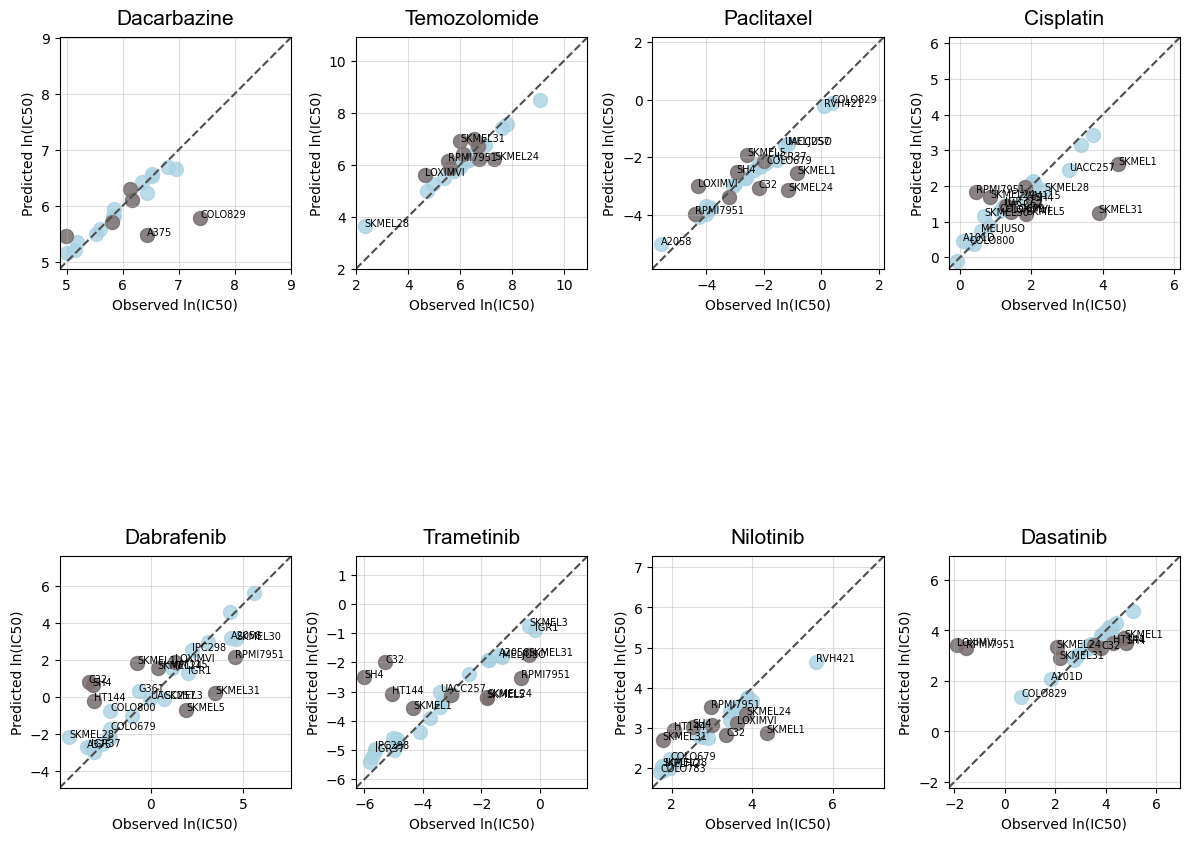

In [513]:
fig, axes = plt.subplots(2, 4, figsize=(12, 12))
axes = axes.flatten()

for i, drug in enumerate(drug_list):
    ax = axes[i]
    
    df_plot = result_df[result_df['Drug']==drug]
    df_plot_test = df_plot[df_plot['Label']=='Test']

    ax.scatter(df_plot['True'], df_plot['Pred'], c='#aad3e3', alpha=0.8, s=100)
    ax.scatter(df_plot_test['True'], df_plot_test['Pred'], c='#7d6c6b', alpha=0.8, s=100)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect('equal')
    ax.set_xlim([min(x0,y0), max(x1,y1)+1.5])
    ax.set_ylim([min(x0,y0), max(x1,y1)+1.5])
    ax.plot([min(x0,y0), max(x1,y1)+1.5], [min(x0,y0), max(x1,y1)+1.5], ls="--", c=".3") 
    ax.set_title(drug, fontdict={'fontsize': 15}, fontname="Arial", y=1.02)
    ax.tick_params(labelsize=10)
    ax.grid(which="major", lw=0.8, alpha=0.4)
    ax.set_xlabel('Observed ln(IC50)')
    ax.set_ylabel('Predicted ln(IC50)')

    for j, txt in enumerate(df_plot['Cell_Line'].values.tolist()):
        if abs(df_plot['True'][j]/df_plot['Pred'][j]-1) > 0.1:
            ax.text(df_plot['True'][j], df_plot['Pred'][j], txt.replace('_SKIN', ''), size=7)

plt.tight_layout()
plt.savefig('plot_{}.png'.format(model_name))

# Show the plot
plt.show()

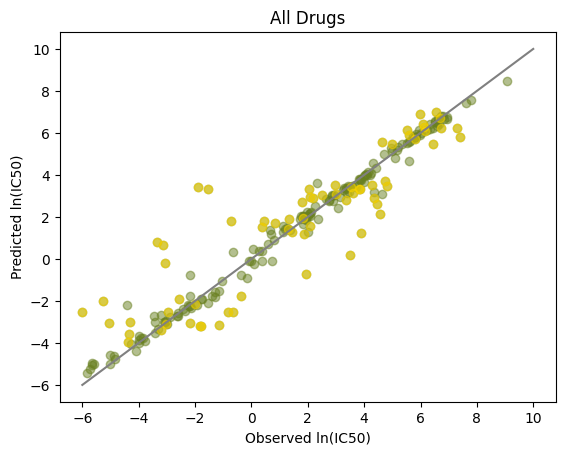

In [514]:
plt.figure()
result_df_test = result_df[result_df['Label']=="Test"]
plt.scatter(result_df['True'], result_df['Pred'], c='#698020', alpha=0.5)
plt.scatter(result_df_test['True'], result_df_test['Pred'], c='#ffd700', alpha=0.5)
plt.plot([-6, 10], [-6, 10], ls="-", c="grey")
plt.title("All Drugs")
plt.xlabel('Observed ln(IC50)')
plt.ylabel('Predicted ln(IC50)')
plt.savefig('plot_all_{}.png'.format(model_name))
plt.show()

## code below is not used

### lasso regression

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e-03, tolerance: 5.249e-04
  model = cd_fast.enet_coordinate_descent(


drug name: Dacarbazine
14 train samples
6 test samples
rmse value = 0.7993999589833597
r-squared value = -0.25539725627634113
------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.326e-03, tolerance: 3.467e-03
  model = cd_fast.enet_coordinate_descent(


drug name: Temozolomide
21 train samples
9 test samples
rmse value = 1.0881423380990825
r-squared value = -1.0792863046429737
------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e-02, tolerance: 4.306e-03
  model = cd_fast.enet_coordinate_descent(


drug name: Paclitaxel
21 train samples
9 test samples
rmse value = 0.9899590683812881
r-squared value = 0.28473176278219137
------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-03, tolerance: 1.835e-03
  model = cd_fast.enet_coordinate_descent(


drug name: Cisplatin
14 train samples
6 test samples
rmse value = 1.3288844184847721
r-squared value = 0.04333895649647379
------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.995e-02, tolerance: 1.410e-02
  model = cd_fast.enet_coordinate_descent(


drug name: Dabrafenib
19 train samples
9 test samples
rmse value = 3.9144391953914357
r-squared value = -0.28885371164470164
------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-02, tolerance: 6.593e-03
  model = cd_fast.enet_coordinate_descent(


drug name: Trametinib
21 train samples
9 test samples
rmse value = 2.1608678865199193
r-squared value = -0.19169815198198492
------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.529e-03, tolerance: 2.121e-03
  model = cd_fast.enet_coordinate_descent(


drug name: Nilotinib
21 train samples
9 test samples
rmse value = 0.7711589441717388
r-squared value = 0.05856107362029539
------------------------------


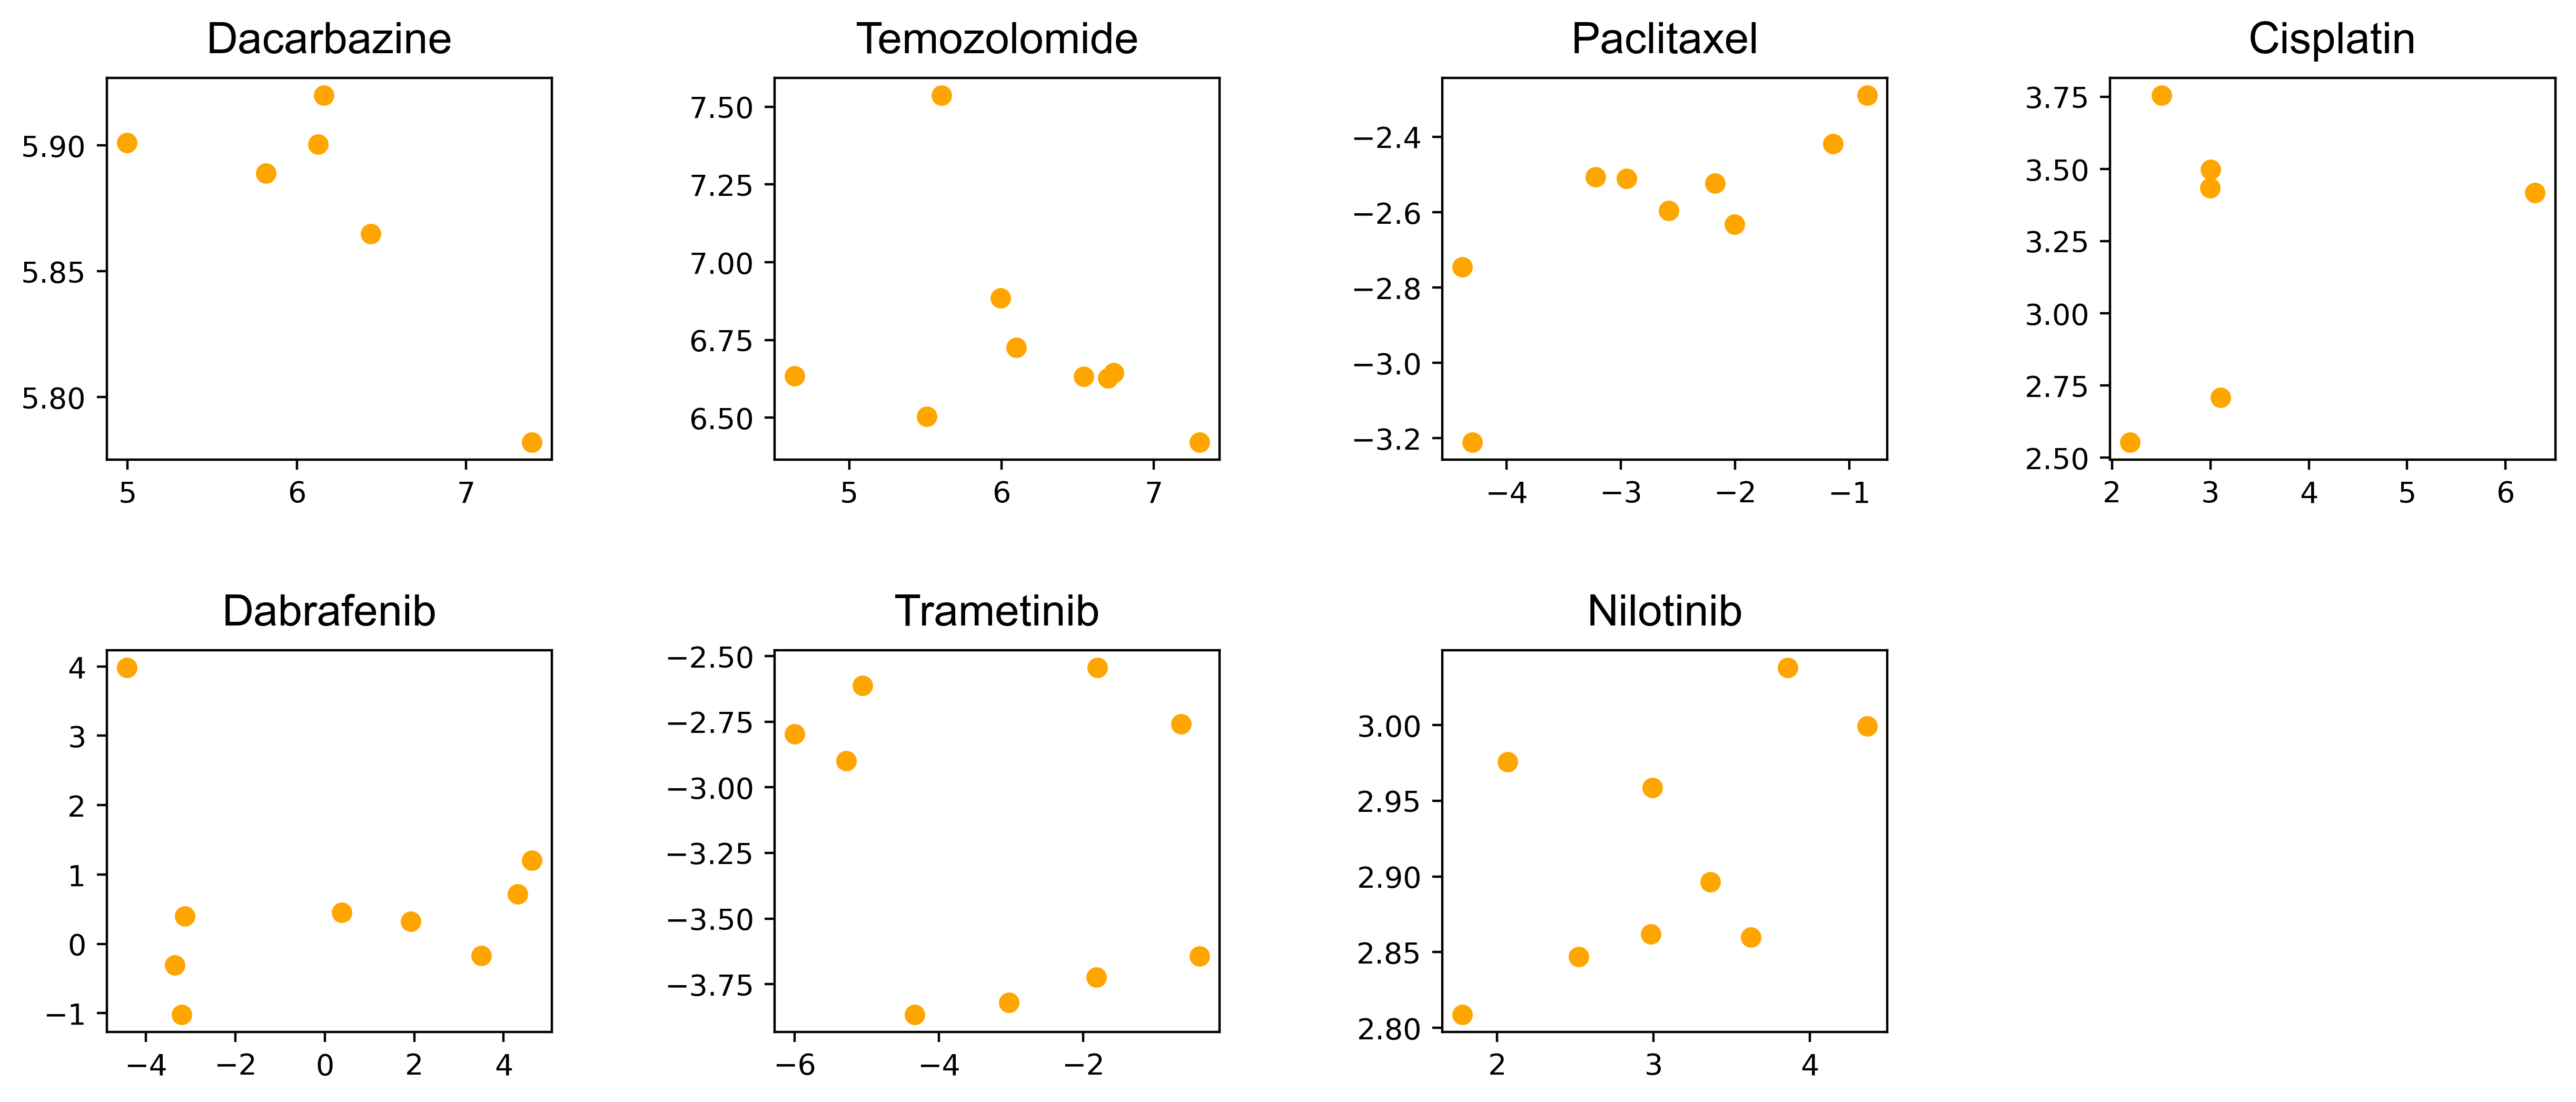

In [136]:
result_df = pd.DataFrame()
rmselist = []
r2list = []

fig = plt.figure(figsize=(15,20),dpi=400)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
num = 1

for drug in drug_list:
    # filter input data to model
    input = data[data['Drug.Name']==drug]

    # train test split
    train, test = train_test_split(input, test_size=0.3, random_state=1)
    
    x_train = train.drop(columns=['cell_line','Drug.Name','IC50'])
    y_train = train['IC50']
    
    x_test = test.drop(columns=['cell_line','Drug.Name','IC50'])
    y_test = test['IC50']

    # train the predictor
    reg = Lasso(alpha=0.001)
    reg.fit(x_train, y_train)

    # test the predictor
    pred_value = reg.predict(x_test)

    df_pred = pd.DataFrame(pred_value).reset_index().drop(columns=['index'])
    df_true = pd.DataFrame(y_test).reset_index().drop(columns=['index'])
    result = pd.concat([df_pred, df_true], axis=1, ignore_index=True)
    result.columns=["Predicted", "Test"]
    #result_df = pd.concat([result_df, result], axis=0)

    # evaluation metrics
    rse = ((result['Predicted']-result['Test'])**2).sum()
    mse = rse / len(result)
    rmse = np.sqrt(mse)
    
    r2_value = r2_score(result['Test'], result['Predicted'])
      
    rmselist.append(rmse)
    r2list.append(r2_value)

    print("drug name: {}".format(drug))
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print("rmse value = {}".format(rmse))
    print("r-squared value = {}".format(r2_value))
    print('-' * 30)

    plt.subplot(6,4,num)
    plt.scatter(y_test, pred_value, c='orange')
    plt.title(drug, fontdict ={'fontsize' : 15}, fontname="Arial", y = 1.02)
    plt.tick_params(labelsize=10)
    
    num += 1


### svr

drug name: Dacarbazine
14 train samples
6 test samples
rmse value = 0.7449974375965117
r-squared value = -0.09034136841005513
------------------------------
drug name: Temozolomide
21 train samples
9 test samples
rmse value = 0.7995307441073249
r-squared value = -0.1225694334880032
------------------------------
drug name: Paclitaxel
21 train samples
9 test samples
rmse value = 1.1754071002450512
r-squared value = -0.008349489799886811
------------------------------
drug name: Cisplatin
14 train samples
6 test samples
rmse value = 1.3677574722942012
r-squared value = -0.01344891711144447
------------------------------
drug name: Dabrafenib
19 train samples
9 test samples
rmse value = 3.4495173243813326
r-squared value = -0.0008780954297018528
------------------------------
drug name: Trametinib
21 train samples
9 test samples
rmse value = 2.013838718501227
r-squared value = -0.0350449436113478
------------------------------
drug name: Nilotinib
21 train samples
9 test samples
rmse valu

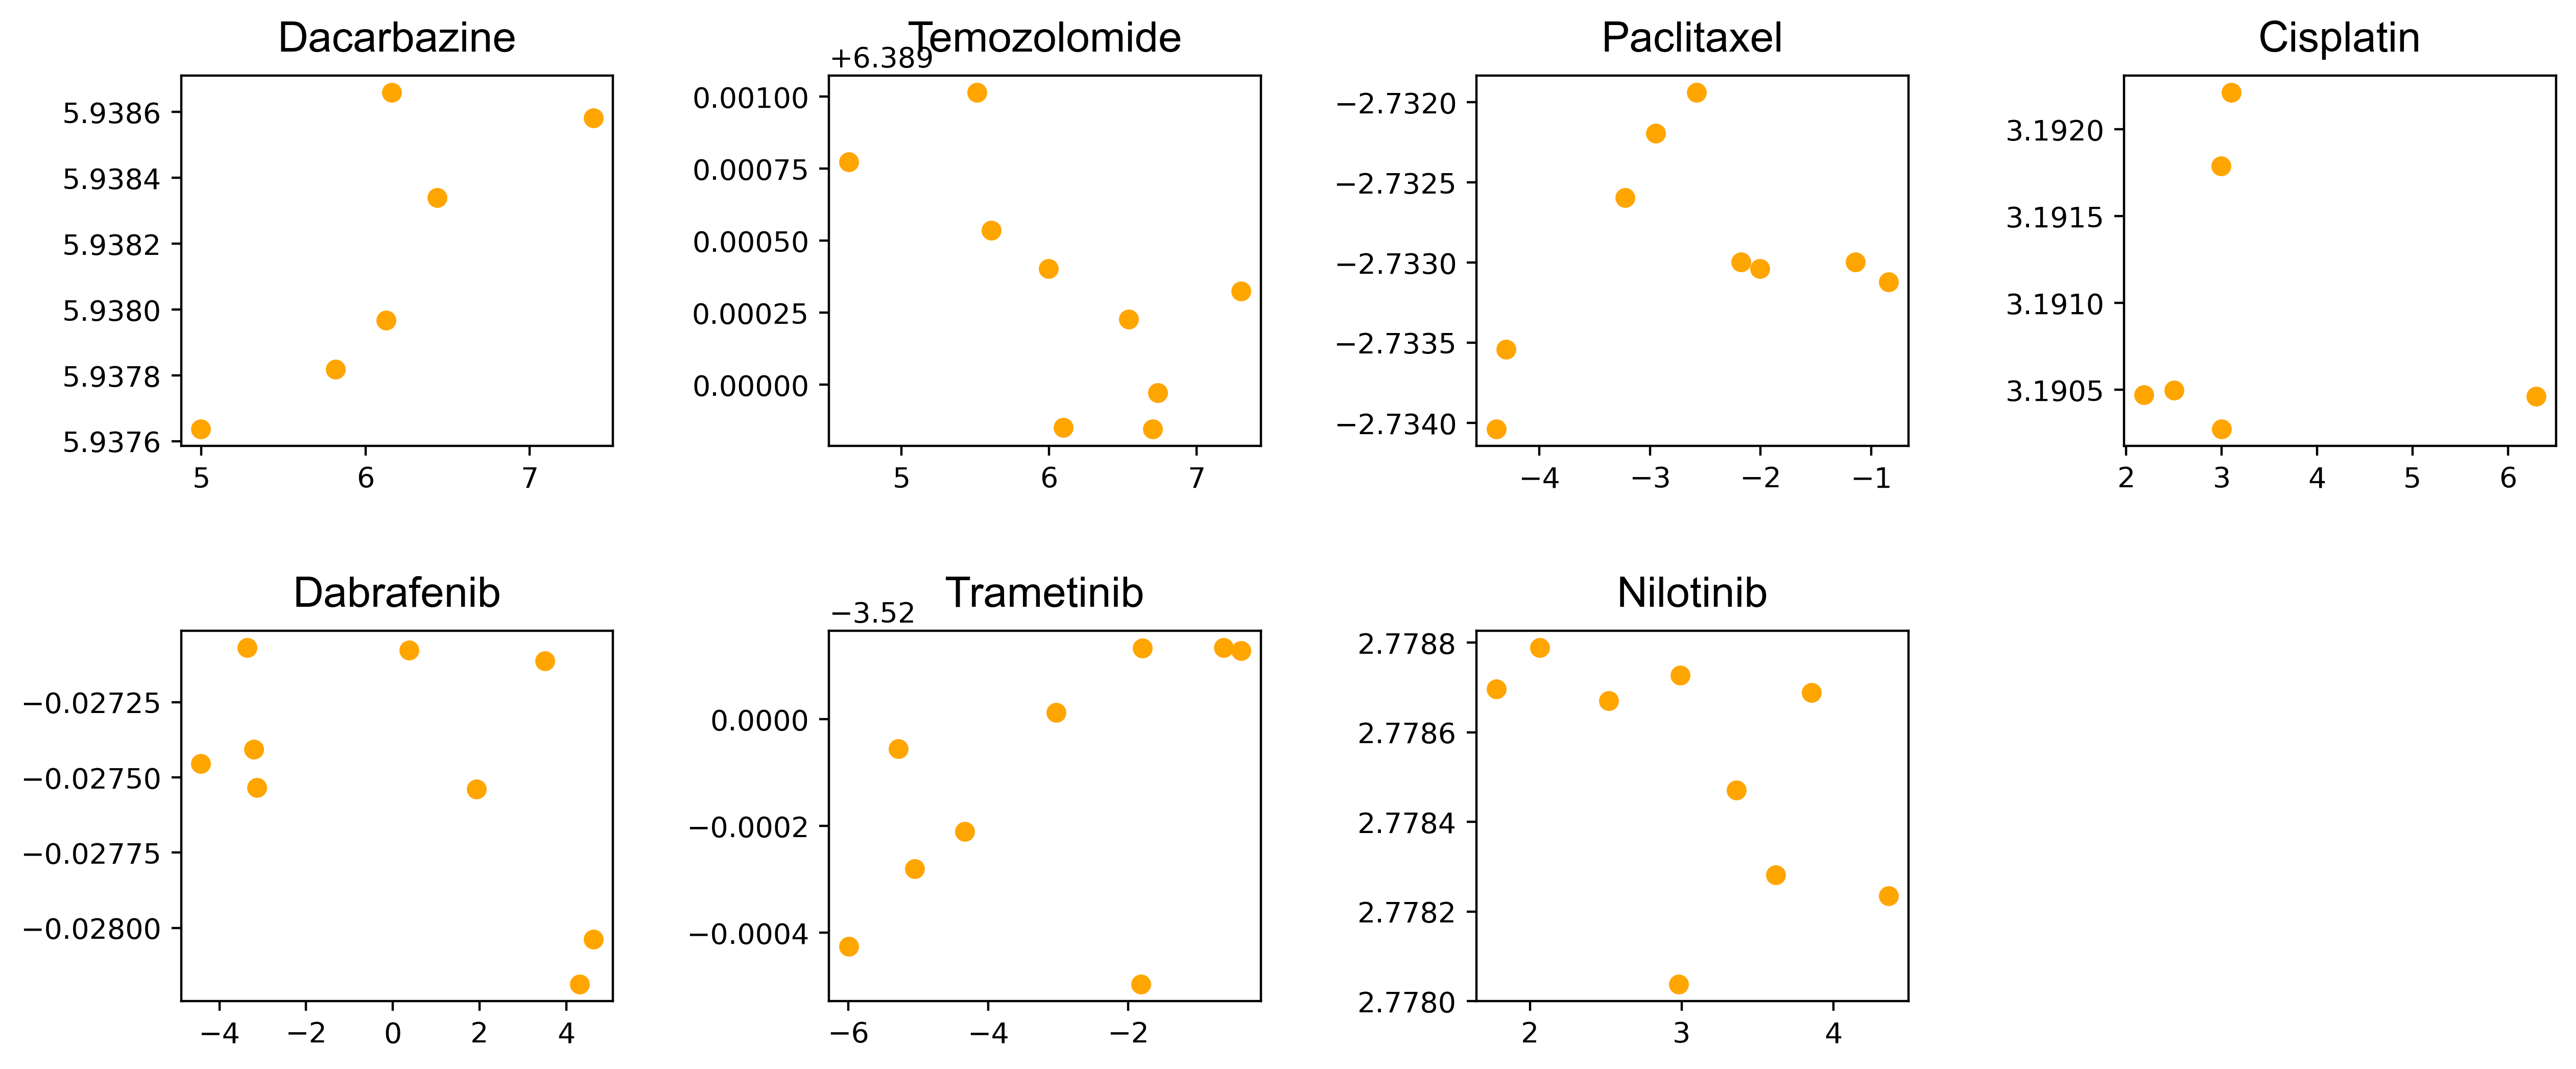

In [140]:
result_df = pd.DataFrame()
rmselist = []
r2list = []

fig = plt.figure(figsize=(15,20),dpi=400)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
num = 1

for drug in drug_list:
    # filter input data to model
    input = data[data['Drug.Name']==drug]

    # train test split
    train, test = train_test_split(input, test_size=0.3, random_state=1)
    
    x_train = train.drop(columns=['cell_line','Drug.Name','IC50'])
    y_train = train['IC50']
    
    x_test = test.drop(columns=['cell_line','Drug.Name','IC50'])
    y_test = test['IC50']

    # train the predictor
    svr = SVR(C=0.01)
    svr.fit(x_train, y_train)

    # test the predictor
    pred_value = svr.predict(x_test)

    df_pred = pd.DataFrame(pred_value).reset_index().drop(columns=['index'])
    df_true = pd.DataFrame(y_test).reset_index().drop(columns=['index'])
    result = pd.concat([df_pred, df_true], axis=1, ignore_index=True)
    result.columns=["Predicted", "Test"]
    #result_df = pd.concat([result_df, result], axis=0)

    # evaluation metrics
    rse = ((result['Predicted']-result['Test'])**2).sum()
    mse = rse / len(result)
    rmse = np.sqrt(mse)
    
    r2_value = r2_score(result['Test'], result['Predicted'])
      
    rmselist.append(rmse)
    r2list.append(r2_value)

    print("drug name: {}".format(drug))
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print("rmse value = {}".format(rmse))
    print("r-squared value = {}".format(r2_value))
    print('-' * 30)

    plt.subplot(6,4,num)
    plt.scatter(y_test, pred_value, c='orange')
    plt.title(drug, fontdict ={'fontsize' : 15}, fontname="Arial", y = 1.02)
    plt.tick_params(labelsize=10)
    
    num += 1


In [478]:
sel_.get_feature_names_out()

AttributeError: 'SelectFromModel' object has no attribute 'feature_names_in_'

In [480]:
model.coef_

array([ 0.01097415, -0.10054611, -0.0228307 ,  0.07690508,  0.00809181,
       -0.05974806,  0.10027088,  0.03913047,  0.06843644, -0.0836017 ,
        0.00279173, -0.08093967,  0.00340464,  0.02582745, -0.10856695,
        0.00595874, -0.07766115, -0.21423599, -0.04877487, -0.05516655,
        0.10112601, -0.08841671])

In [481]:
model.feature_names_in_

AttributeError: 'LinearRegression' object has no attribute 'feature_names_in_'